In [1]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import infer, poutine
from pyro.infer import Importance, EmpiricalMarginal, SMCFilter
plt.style.use("seaborn-v0_8")

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LinearStateModel:
    def __init__(self):
        self.A = torch.tensor([[1.0, 0], [0, -3.0]])
        self.v = torch.tensor([1.0, 0.5])
        self.e = torch.tensor([0.5, 0.5])
    
    def init(self, state, initial):
        self.t = 0
        state["z"] = pyro.sample(f"z_{self.t}", dist.Delta(initial).to_event(1))
                    
    def step(self, state, y=None):
        
        self.t += 1
        state["z"] = pyro.sample(f"z_{self.t}", dist.Normal(state["z"] @ self.A,
                                                            self.v).to_event(1))
        state["y"] = pyro.sample(f"y_{self.t}", dist.Normal(state["z"], 
                                                            self.e).to_event(1), obs=y)
        return state["z"], state["y"], self.t
    
class LinearStateGuide:
    
    def __init__(self, model):
        self.model = model
    
    def init(self, state, initial):
        self.t = 0
        pyro.sample(f"z_{self.t}", dist.Delta(initial).to_event(1))

    def step(self, state, y=None):
        self.t += 1
        pyro.sample("z_{}".format(self.t), dist.Normal(state["z"] @ self.model.A, 
                                                       torch.tensor([1.0, 1.0])).to_event(1))
        

In [3]:
def generate_data(initial=torch.zeros(2), T=5):
    model = LinearStateModel()
    state = {}
    model.init(state, initial)
    z, y = [state["z"]], []
    for t in range(1, T+1):
        model.step(state)
        z.append(state[f"z"])
        y.append(state[f"y"])
    
    return torch.stack(z), torch.stack(y)

In [4]:
data_z, data_y = generate_data(T=10)

In [5]:
data_y

tensor([[ 4.0913e-01, -7.8016e-01],
        [ 1.7357e+00,  3.6217e+00],
        [ 1.3733e+00, -9.8746e+00],
        [ 2.3304e+00,  2.8083e+01],
        [ 2.0464e+00, -8.6037e+01],
        [ 2.5511e+00,  2.5644e+02],
        [ 1.5577e+00, -7.6864e+02],
        [ 1.0704e+00,  2.3060e+03],
        [-2.0060e-01, -6.9192e+03],
        [-1.6632e+00,  2.0758e+04]])

In [6]:
data_y.unbind(1)

(tensor([ 0.4091,  1.7357,  1.3733,  2.3304,  2.0464,  2.5511,  1.5577,  1.0704,
         -0.2006, -1.6632]),
 tensor([-7.8016e-01,  3.6217e+00, -9.8746e+00,  2.8083e+01, -8.6037e+01,
          2.5644e+02, -7.6864e+02,  2.3060e+03, -6.9192e+03,  2.0758e+04]))

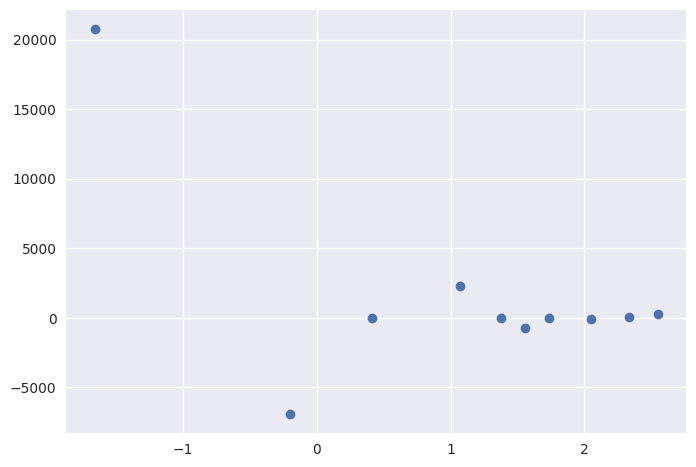

In [7]:
plt.plot(*data_y.unbind(1), "o")

In [8]:
data_y

tensor([[ 4.0913e-01, -7.8016e-01],
        [ 1.7357e+00,  3.6217e+00],
        [ 1.3733e+00, -9.8746e+00],
        [ 2.3304e+00,  2.8083e+01],
        [ 2.0464e+00, -8.6037e+01],
        [ 2.5511e+00,  2.5644e+02],
        [ 1.5577e+00, -7.6864e+02],
        [ 1.0704e+00,  2.3060e+03],
        [-2.0060e-01, -6.9192e+03],
        [-1.6632e+00,  2.0758e+04]])

In [9]:
pyro.clear_param_store()
pyro.set_rng_seed(100)
model = LinearStateModel()
guide = LinearStateGuide(model)
smc = SMCFilter(model=model, guide=guide, num_particles=200, max_plate_nesting=0)
smc.init(initial=torch.tensor([1.0, 0.0]))
for y in data_y:
   smc.step(y.expand(200, -1))

In [11]:
emp = smc.get_empirical()["y"]

In [14]:
emp._samples.size()

torch.Size([200, 2])

In [15]:
emp._samples.mean()

tensor(10378.3252)